In [35]:
pip install requests beautifulsoup4 robustbase


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Basmala Kamal\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [83]:
import requests
from bs4 import BeautifulSoup
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
import numpy as np
from sklearn.preprocessing import MinMaxScaler



In [124]:
import json
import pandas as pd
import re

# 1. Load the JSON file
with open("B:/tut-pricing-model/shopify/shopify/shopify/spiders/sourcebeauty_makeupresults_withbrand_20250611_122636.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert to a pandas DataFrame for easier data manipulation
df = pd.DataFrame(data)
df = df.dropna(subset=["price"])
import time


# Define the function to scrape the brand name
def scrape_brand_name(session, url):
    try:
        if not url or not url.startswith("http"):  # Validate URL
            return None

        # Send a GET request to the URL using the session
        response = session.get(url, timeout=10)
        response.raise_for_status()  # Raise an error for HTTP issues

        # Parse the page content with BeautifulSoup
        soup = BeautifulSoup(response.content, "html.parser")

        # Adjust this selector based on the actual structure of the webpage
        brand_tag = soup.find("tr", class_="a-spacing-small po-brand")
        if brand_tag:
            td_tag = brand_tag.find("td", class_="a-span9")
            if td_tag:
                span_tag = td_tag.find("span", class_="a-size-base po-break-word")
                if span_tag:
                    return span_tag.get_text(strip=True)

        # Return None if the brand name is not found
        return None

    except requests.exceptions.RequestException as e:
        print(f"Network error scraping {url}: {e}")
        return None
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None

# Load the JSON file

"""
# Ensure the 'link' column exists and is valid
if "link" in df.columns:
    # Create a requests session
    with requests.Session() as session:
        # Set a User-Agent header to mimic a browser (optional but recommended)
        session.headers.update({
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
        })

        # Apply the scraping function to the 'link' column
        brand_names = []
        for idx, url in enumerate(df["link"]):
            print(f"Scraping {idx + 1}/{len(df)}: {url}")
            brand_name = scrape_brand_name(session, url)
            brand_names.append(brand_name)

            # Throttle requests to avoid getting blocked
            time.sleep(2)

        # Add the scraped brand names to the DataFrame
        df["brand_name"] = brand_names"""

def clean_price(price_str):
    if price_str is None:
        return None
    numeric_str = re.sub(r"[^\d\.]", "", price_str)
    try:
        return float(numeric_str)
    except ValueError:
        return None

df["price_numeric"] = df["price"].apply(clean_price)


def clean_rating(rating_str):
    if rating_str is None:
        return None

    match = re.search(r"\d+(\.\d+)?", rating_str)
    if match:
        try:
            return float(match.group(0))
        except ValueError:
            return None
    return None

#df["rating_numeric"] = df["rating"].apply(clean_rating)

def extract_volume(title_str):
    # Check for "ml" first to avoid misidentification
    match_ml = re.search(r'(\d+(?:\.\d+)?)\s*ml', title_str, re.IGNORECASE)
    if match_ml:
        return float(match_ml.group(1))  # Prioritize ml if present
    else:
    # Check for "oz" (fluid ounces)
      match_oz = re.search(r'(\d+(?:\.\d+)?)\s*(?:fl\.?\s*oz|oz|fluid ounces?)', title_str, re.IGNORECASE)
      if match_oz:
         return float(match_oz.group(1)) * 29.5735  # Convert oz to ml

    # If no match, return None
    return None

# Apply the function to the DataFrame
df["volume"] = df["name"].apply(extract_volume)

def remove_duplicates_by_name_and_price(df):
    # Sort the DataFrame to keep the first occurrence of each duplicate
    df = df.sort_values(by=["name", "price_numeric"])

    # Drop duplicates based on 'name' and 'price_numeric'
    df = df.drop_duplicates(subset=["name", "price_numeric"], keep="first")

    return df

# Apply the duplicate removal function to the DataFrame
df = remove_duplicates_by_name_and_price(df)
# ------------------------------------------------------------------------------
# Final cleaned DataFrame
df = df[~df['name'].str.contains("antiperspirant|Antiperspirant", na=False)].copy()
print(df)


                                               name       price  \
151   20H Ultra Precision Gel Eye Pencil Waterproof  EGP 223.00   
150                         3D Brow Two Tone Pomade  EGP 410.00   
236                       3Dimension Volume Mascara  EGP 400.00   
42                         8H Matte Liquid Lipstick  EGP 250.00   
1556                                     Accent 308   EGP 89.00   
...                                             ...         ...   
941                                Wet & Dry Powder  EGP 286.00   
1129                Whitening Eye Contour Concealer  EGP 199.00   
1558                                    Wispies 600  EGP 185.00   
1559                                    Wispies 603  EGP 185.00   
1560                                    Wispies 700  EGP 185.00   

                                            description     brand  page  \
151   Make your eyes pop with bold, metallic colour ...   Catrice     4   
150   Define and set your brows effortlessly 

In [125]:
print(df.columns)

Index(['name', 'price', 'description', 'brand', 'page', 'url', 'price_numeric',
       'volume'],
      dtype='object')


In [126]:
"""import pandas as pd
from difflib import SequenceMatcher




def is_body_splash_or_fragrance(name):
    name = str(name).lower()
    
    # Keywords that must appear or match closely
    keywords = [
        "body splash", "fragrance mist", "body mist", "body spray",
        "perfume", "eau de toilette", "eau de parfum", "fragrance", "mist", "spray"
    ]

    # Optional: Exclude unrelated mist products (e.g., setting spray, toner)
    exclude_keywords = [
        "setting spray", "toner", "serum", "deodorant", "sunscreen"
    ]

    for exclude in exclude_keywords:
        if exclude in name:
            return False

    for keyword in keywords:
        if keyword in name or SequenceMatcher(None, keyword, name).ratio() > 0.7:
            return True

    return False


# --- Step 3: Filter for splash-related items only ---
df_cleaned = df_cleaned[df_cleaned["name"].apply(is_body_splash_or_fragrance)]

# --- Step 4: Remove known unrelated items (e.g., deodorants, antiperspirants) ---
df_cleaned = df_cleaned[~df_cleaned["name"].str.contains("antiperspirant|deodorant|deo", case=False, na=False)]
"""
df_cleaned = df.copy()
# --- Step 5: Define multi-item set detection ---
def is_multi_item(name):
    if "+" in name:
        return True
    name = str(name).lower()
    if "multipack" in name or "box" in name:
        return True
    # Case 1: Set & Pieces
    if "set" in name and ("pieces" in name or "bundle" in name or "pack" in name):
        return True
    # Case 2: Multi-pack or similar
    if re.search(r"(2-pack|two-pack|2 bottles|two bottles|two items|two)", name, re.IGNORECASE):
        return True
    
    # Case 3: Numeric quantities
    if re.search(r"\b\d+\s*(bottles|packs?|count|piece|pieces)\b", name, re.IGNORECASE):
        return True

    return False

# --- Step 6: Remove multi-item sets ---
df_cleaned = df_cleaned[~df_cleaned["name"].apply(is_multi_item)]

# --- Step 7: Final cleanup ---
df_cleaned.reset_index(drop=True, inplace=True)

# --- Step 8: Preview ---
print("Final cleaned dataset shape:", df_cleaned.shape)
print(df_cleaned.head())


Final cleaned dataset shape: (235, 8)
                                            name       price  \
0  20H Ultra Precision Gel Eye Pencil Waterproof  EGP 223.00   
1                      3Dimension Volume Mascara  EGP 400.00   
2                       8H Matte Liquid Lipstick  EGP 250.00   
3                                     Accent 308   EGP 89.00   
4                                     Accent 311   EGP 89.00   

                                         description     brand  page  \
0  Make your eyes pop with bold, metallic colour ...   Catrice     4   
1  Experience customizable lash volume with 3Dime...  Top Face     5   
2  Enjoy a bold, matte look that lasts with the 8...   Essence     2   
3  Get the full look with Ardell Lash Accent 308....    Ardell    14   
4  Experience a blend of elegance and flirtation ...    Ardell    14   

                                                 url  price_numeric volume  
0  https://sourcebeauty.com/collections/makeup?ta...          223.0

In [127]:
print(df_cleaned.columns.tolist())


['name', 'price', 'description', 'brand', 'page', 'url', 'price_numeric', 'volume']


In [88]:
"""# Step 1: Ensure volume and price_numeric columns exist and are not accidentally DataFrames
print(type(df_cleaned["volume"]), type(df_cleaned["price_numeric"]))

# Step 2: Create the new column safely
# Ensure 'price_numeric' and 'volume' exist
if "price_numeric" in df_cleaned.columns and "volume" in df_cleaned.columns:
    df_cleaned["price_per_volume"] = df_cleaned.apply(
        lambda row: row["price_numeric"] / row["volume"]
        if pd.notna(row["price_numeric"]) and pd.notna(row["volume"]) and row["volume"] > 0
        else np.nan,
        axis=1
    )
else:
    print("Missing 'price_numeric' or 'volume' columns.")

"""

'# Step 1: Ensure volume and price_numeric columns exist and are not accidentally DataFrames\nprint(type(df_cleaned["volume"]), type(df_cleaned["price_numeric"]))\n\n# Step 2: Create the new column safely\n# Ensure \'price_numeric\' and \'volume\' exist\nif "price_numeric" in df_cleaned.columns and "volume" in df_cleaned.columns:\n    df_cleaned["price_per_volume"] = df_cleaned.apply(\n        lambda row: row["price_numeric"] / row["volume"]\n        if pd.notna(row["price_numeric"]) and pd.notna(row["volume"]) and row["volume"] > 0\n        else np.nan,\n        axis=1\n    )\nelse:\n    print("Missing \'price_numeric\' or \'volume\' columns.")\n\n'

In [128]:
print(df_cleaned["price_numeric"].describe())
df_cleaned["price_numeric"].dropna()


count    235.000000
mean     285.173532
std      134.261827
min       60.000000
25%      190.625000
50%      250.000000
75%      370.000000
max      740.000000
Name: price_numeric, dtype: float64


0      223.0
1      400.0
2      250.0
3       89.0
4       89.0
       ...  
230    286.0
231    199.0
232    185.0
233    185.0
234    185.0
Name: price_numeric, Length: 235, dtype: float64

In [71]:
#print(df_cleaned["price_per_volume"].describe())


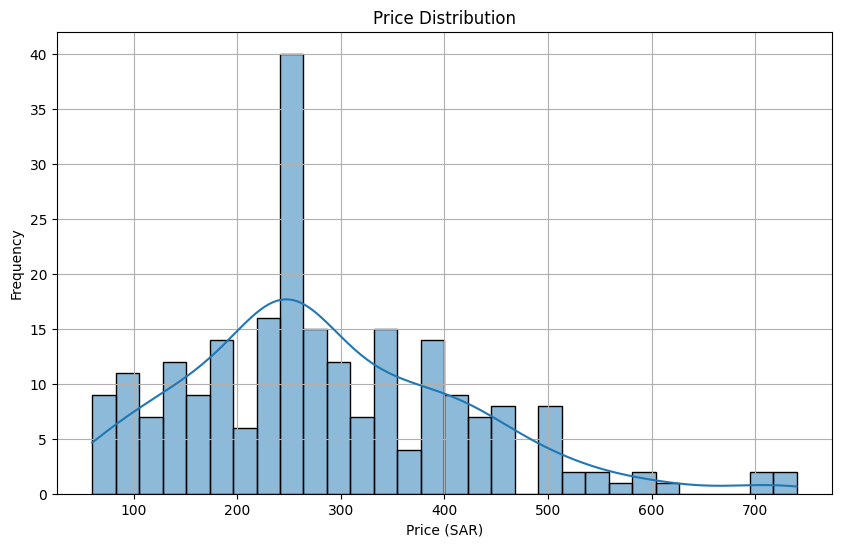

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned["price_numeric"].dropna(), bins=30, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price (SAR)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [130]:
import numpy as np
from sklearn.preprocessing import StandardScaler

#df_cleaned = df_cleaned.dropna(subset=["price_per_volume"]).copy()

# Apply log transformation using .loc
df_cleaned.loc[:, "price_log"] = np.log(df_cleaned["price_numeric"])

# Then standard scale
scaler = StandardScaler()
df_cleaned.loc[:, "price_scaled"] = scaler.fit_transform(df_cleaned[["price_log"]])


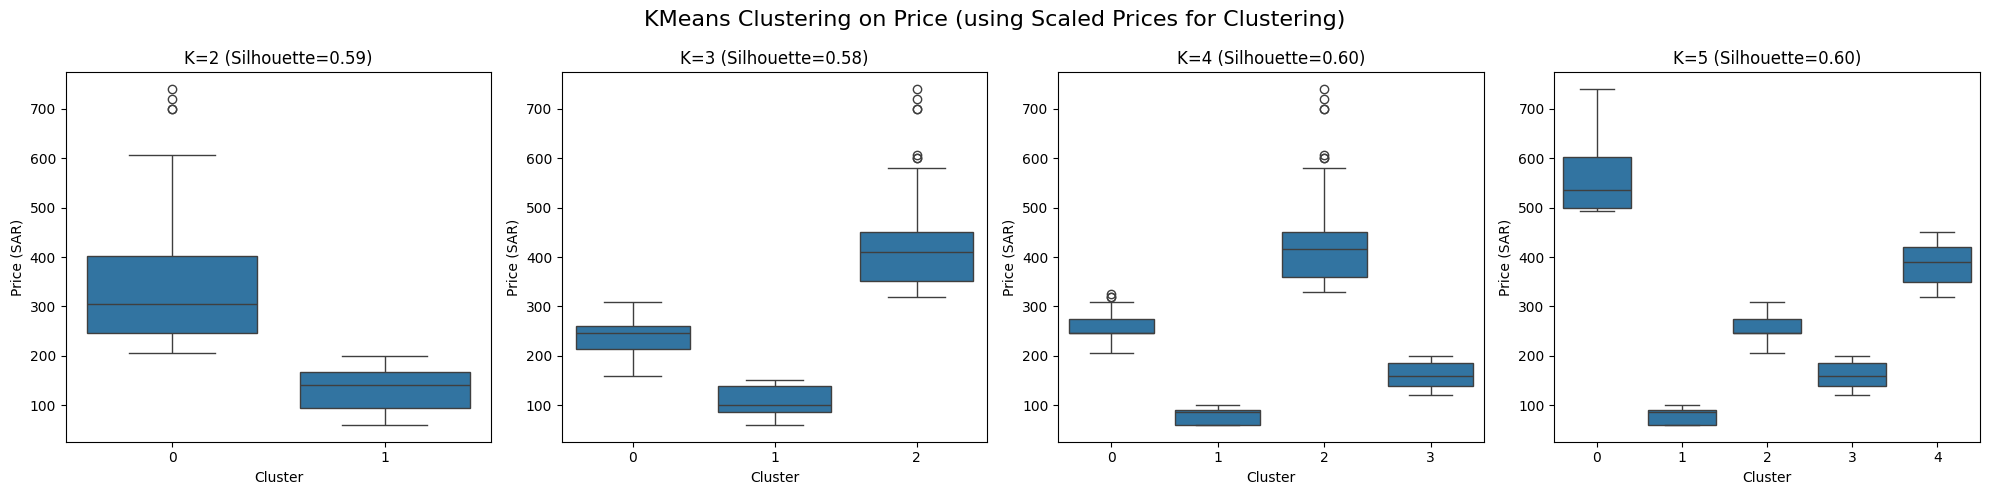

In [131]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# 2. Feature for clustering
X_price = df_cleaned[["price_scaled"]].values

# 3. Plot setup
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 4. Try multiple cluster counts
for idx, k in enumerate([2, 3, 4, 5]):
    if len(df_cleaned) < k:
        print(f"Skipping k={k} due to insufficient data.")
        continue

    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)

    # Add cluster labels to DataFrame
    cluster_col = f"cluster_k{k}"
    df_cleaned[cluster_col] = kmeans.labels_

    # Silhouette score
    if len(set(kmeans.labels_)) > 1:
        sil_score = silhouette_score(X_price, kmeans.labels_)
    else:
        sil_score = np.nan

    # Boxplot using raw prices, grouped by cluster
    sns.boxplot(
        x=cluster_col,
        y="price_numeric",  # Show real prices
        data=df_cleaned,
        ax=axes[idx]
    )
    axes[idx].set_title(f"K={k} (Silhouette={sil_score:.2f})")
    axes[idx].set_xlabel("Cluster")
    axes[idx].set_ylabel("Price (SAR)")

# Final plot formatting
plt.suptitle("KMeans Clustering on Price (using Scaled Prices for Clustering)", fontsize=16)
plt.tight_layout()
plt.show()


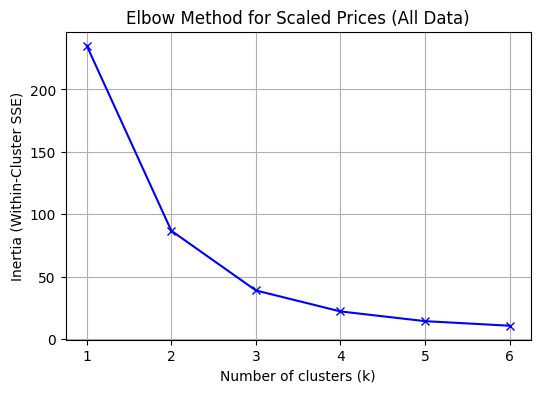

In [132]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract scaled price for clustering
X_price = df_cleaned[["price_scaled"]].values

# Elbow Method: Try k from 2 to 5
distortions = []
K_range = range(1, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, distortions, 'bx-')
plt.title('Elbow Method for Scaled Prices (All Data)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster SSE)')
plt.xticks(K_range)
plt.grid(True)
plt.show()


In [168]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# 1. Extract price_scaled values for clustering
X_price = df_cleaned[["price_scaled"]].values

# 2. Run KMeans with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X_price)

# 3. Reassign cluster labels based on ascending mean price
df_cleaned = df_cleaned.copy()
df_cleaned["temp_cluster"] = kmeans.labels_

# Calculate mean price per cluster
cluster_means = (
    df_cleaned.groupby("temp_cluster")["price_numeric"]
    .mean()
    .sort_values()
    .reset_index()
)

# Create a mapping from original label to sorted label (e.g. {2: 0, 0: 1, 1: 2})
label_mapping = dict(zip(cluster_means["temp_cluster"], cluster_means.index))


# Apply new labels
df_cleaned["final_cluster"] = df_cleaned["temp_cluster"].map(label_mapping)
df_cleaned.drop(columns=["temp_cluster"], inplace=True)

# 4. Show actual price statistics per sorted cluster
summary = (
    df_cleaned
    .groupby("final_cluster")["price_numeric"]
    .agg(["count", "mean", "min", "max"])
    .sort_values(by="mean", ascending=True)
    .reset_index()
)


print("Cluster Summary Based on Actual Prices (SAR):")
print(summary)
lowest_cluster = summary.index[0]
mid_cluster = summary.index[1]
highest_cluster = summary.index[2]


Cluster Summary Based on Actual Prices (SAR):
   final_cluster  count        mean    min    max
0              0     39  106.872564   60.0  150.0
1              1    112  238.518393  159.0  308.0
2              2     84  430.162976  318.7  740.0


In [167]:
"""import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Make sure 'price_numeric' exists in df_cleaned
df_cleaned = df_cleaned.copy()

# Prepare actual price data
X_price = df_cleaned[["price_numeric"]].values

# Run KMeans on actual prices
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X_price)
df_cleaned["final_cluster"] = kmeans.labels_

# Plotting clusters based on actual price
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue']

for cluster in range(k):
    cluster_points = df_cleaned[df_cleaned["final_cluster"] == cluster]
    plt.scatter(cluster_points["price_numeric"], [0] * len(cluster_points),
                label=f"Cluster {cluster}", alpha=0.6, color=colors[cluster])

# Cluster centers (actual price values)
centers = kmeans.cluster_centers_.flatten()
plt.scatter(centers, [0] * k, c='black', s=200, marker='x', label='Centers')

# Plot config
plt.title("KMeans Clustering on Actual Price")
plt.xlabel("Price (SAR)")
plt.yticks([])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
"""

'import pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.cluster import KMeans\n\n# Make sure \'price_numeric\' exists in df_cleaned\ndf_cleaned = df_cleaned.copy()\n\n# Prepare actual price data\nX_price = df_cleaned[["price_numeric"]].values\n\n# Run KMeans on actual prices\nk = 3\nkmeans = KMeans(n_clusters=k, random_state=0, n_init=10)\nkmeans.fit(X_price)\ndf_cleaned["final_cluster"] = kmeans.labels_\n\n# Plotting clusters based on actual price\nplt.figure(figsize=(10, 6))\ncolors = [\'red\', \'green\', \'blue\']\n\nfor cluster in range(k):\n    cluster_points = df_cleaned[df_cleaned["final_cluster"] == cluster]\n    plt.scatter(cluster_points["price_numeric"], [0] * len(cluster_points),\n                label=f"Cluster {cluster}", alpha=0.6, color=colors[cluster])\n\n# Cluster centers (actual price values)\ncenters = kmeans.cluster_centers_.flatten()\nplt.scatter(centers, [0] * k, c=\'black\', s=200, marker=\'x\', label=\'Centers\')\n\n# Plot config

In [169]:
low = df_cleaned[
    (df_cleaned["final_cluster"] == lowest_cluster)
]
low

,name,price,description,brand,page,url,price_numeric,volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
3,Accent 308,EGP 89.00,Get the full look with Ardell Lash Accent 308....,Ardell,14,https://sourcebeauty.com/collections/makeup?ta...,89.00,None,4.488636,-1.968305,1,1,1,1,0
4,Accent 311,EGP 89.00,Experience a blend of elegance and flirtation ...,Ardell,14,https://sourcebeauty.com/collections/makeup?ta...,89.00,None,4.488636,-1.968305,1,1,1,1,0
25,Cheek Tint,EGP 125.00,Add a subtle glow to your routine with Orglam'...,Orglam,9,https://sourcebeauty.com/collections/makeup?ta...,125.00,None,4.828314,-1.325794,1,1,3,3,0
41,Eye Brow Mascara,EGP 90.00,Enhance and define your brows effortlessly wit...,Ciao Cosmetics,12,https://sourcebeauty.com/collections/makeup?ta...,90.00,None,4.499810,-1.947170,1,1,1,1,0
44,Eyebrow Pencil,EGP 138.00,Achieve flawless and natural-looking brows eff...,Luna,13,https://sourcebeauty.com/collections/makeup?ta...,138.00,None,4.927254,-1.138646,1,1,3,3,0
46,Eyebrow Powder,EGP 143.00,"Achieve fuller, thicker, and defined brows eff...",Luna,11,https://sourcebeauty.com/collections/makeup?ta...,143.00,None,4.962845,-1.071325,1,1,3,3,0
48,Eyeshadow,EGP 138.00,Discover the Eye Shadow Ultra Fine Powder from...,Luna,11,https://sourcebeauty.com/collections/makeup?ta...,138.00,None,4.927254,-1.138646,1,1,3,3,0
50,Fard blusher,EGP 90.03,Get a radiant and natural flush with Ciao Cosm...,Ciao Cosmetics,12,https://sourcebeauty.com/collections/makeup?ta...,90.03,None,4.500143,-1.946540,1,1,1,1,0
54,Flawless Finish Concealer,EGP 120.00,"Introducing Ciao's liquid concealer, which off...",Ciao Cosmetics,12,https://sourcebeauty.com/collections/makeup?ta...,120.00,None,4.787492,-1.403010,1,1,3,3,0
67,Glamour 138,EGP 90.00,Hello Beautiful! Are you in search of the perf...,Ardell,14,https://sourcebeauty.com/collections/makeup?ta...,90.00,None,4.499810,-1.947170,1,1,1,1,0


In [170]:
unique_brands_low = set(low['brand'].unique())

# Show the result
print(unique_brands_low)

{'Glow-Up', 'Essence', 'Nankar', 'Maward', 'Amanda Milano', 'Ciao Cosmetics', 'Luna', 'Ardell', 'Top Face', 'Orglam', 'Manella'}


In [171]:
mid = df_cleaned[
    (df_cleaned["final_cluster"] == 1)
]
mid

,name,price,description,brand,page,url,price_numeric,volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
0,20H Ultra Precision Gel Eye Pencil Waterproof,EGP 223.00,"Make your eyes pop with bold, metallic colour ...",Catrice,4,https://sourcebeauty.com/collections/makeup?ta...,223.0,None,5.407172,-0.230866,0,0,0,2,1
2,8H Matte Liquid Lipstick,EGP 250.00,"Enjoy a bold, matte look that lasts with the 8...",Essence,2,https://sourcebeauty.com/collections/makeup?ta...,250.0,None,5.521461,-0.014684,0,0,0,2,1
6,Ageless Radiance Eye Concealer,EGP 299.00,"Experience brighter, more refreshed eyes with ...",Cleajour,9,https://sourcebeauty.com/collections/makeup?ta...,299.0,None,5.700444,0.323867,0,0,0,2,1
8,Aqua Lashes - 341,EGP 237.00,Enjoy a flawless look in seconds with Ardell's...,Ardell,8,https://sourcebeauty.com/collections/makeup?ta...,237.0,None,5.468060,-0.115694,0,0,0,2,1
9,BAYEB Eyebrows Gel,EGP 269.00,Achieve impeccably groomed and well-defined ey...,DEOC Cosmetics,12,https://sourcebeauty.com/collections/makeup?ta...,269.0,None,5.594711,0.123871,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,Wet & Dry Powder,EGP 286.00,Elevate your skincare routine with this amazin...,Luna,11,https://sourcebeauty.com/collections/makeup?ta...,286.0,None,5.655992,0.239785,0,0,0,2,1
231,Whitening Eye Contour Concealer,EGP 199.00,Introducing Drakon's Whitening Eye Contour Con...,Drakon,12,https://sourcebeauty.com/collections/makeup?ta...,199.0,None,5.293305,-0.446249,1,0,3,3,1
232,Wispies 600,EGP 185.00,Ardell's Wispies 600 lashes create an attracti...,Ardell,14,https://sourcebeauty.com/collections/makeup?ta...,185.0,None,5.220356,-0.584234,1,0,3,3,1
233,Wispies 603,EGP 185.00,Ardell's Wispies 700 lashes are the newest sty...,Ardell,14,https://sourcebeauty.com/collections/makeup?ta...,185.0,None,5.220356,-0.584234,1,0,3,3,1


In [172]:
unique_brands_mid = set(mid['brand'])

# Show the result
print(unique_brands_mid)

{'Essentials', 'Tulips', 'Favelin', 'Donna Natural', 'Queen By Lord', 'Flormar', 'Trace Cosmetics', 'Amanda Milano', 'Catrice', 'Orglam', 'Kinetics', 'Azha Med', 'Essence', 'Maybelline New York', 'DEOC Cosmetics', 'Cleajour', 'Cybele', 'Ardell', 'Top Face', 'Rhea Beauty', 'Buend', 'Luna', 'Drakon', 'Source Beauty'}


In [173]:
high = df_cleaned[
    (df_cleaned["final_cluster"] == 2)
]
high

,name,price,description,brand,page,url,price_numeric,volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
1,3Dimension Volume Mascara,EGP 400.00,Experience customizable lash volume with 3Dime...,Top Face,5,https://sourcebeauty.com/collections/makeup?ta...,400.0,None,5.991465,0.874342,0,2,2,4,2
5,Acti-Solaire Melting Cream - Light Tinted,EGP 319.00,Fortify your skin against the sun's harmful ef...,Dermactive,10,https://sourcebeauty.com/collections/makeup?ta...,319.0,None,5.765191,0.446339,0,2,0,4,2
7,Angled Brow Pencil,EGP 545.00,"Achieve fuller, perfectly shaped brows with th...",Flormar,3,https://sourcebeauty.com/collections/makeup?ta...,545.0,None,6.300786,1.459433,0,2,2,0,2
11,BB Cream Matte Finish,EGP 390.00,"Experience a flawless, smooth complexion with ...",Top Face,5,https://sourcebeauty.com/collections/makeup?ta...,390.0,None,5.966147,0.826453,0,2,2,4,2
12,Baked Blush On,EGP 607.60,Add a natural flush to your cheeks with the Ba...,Flormar,2,https://sourcebeauty.com/collections/makeup?ta...,607.6,None,6.409517,1.665101,0,2,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,The Rose Edition Eyeshadow Palette,EGP 360.00,Express your style with the 9 highly pigmented...,Essence,2,https://sourcebeauty.com/collections/makeup?ta...,360.0,None,5.886104,0.675049,0,2,2,4,2
219,Tinted Brow Gel,EGP 420.00,Define and volumize your brows with the Tinted...,Flormar,3,https://sourcebeauty.com/collections/makeup?ta...,420.0,None,6.040255,0.966630,0,2,2,4,2
220,Tinted Kit,EGP 420.00,"Get your glow with this amazing tinted kit, fe...",The Bath Land,10,https://sourcebeauty.com/collections/makeup?ta...,420.0,None,6.040255,0.966630,0,2,2,4,2
223,True Skin Hydrating Foundation,EGP 508.00,"Enjoy a smooth, natural complexion with the Tr...",Catrice,4,https://sourcebeauty.com/collections/makeup?ta...,508.0,None,6.230481,1.326450,0,2,2,0,2


In [174]:
unique_brands_high = set(high['brand'])

# Show the result
print(unique_brands_high)

{'Essentials', 'Laque', 'The Bath Land', 'Technic Cosmetics', 'Flormar', 'Note Cosmetique', 'Amanda Milano', 'Catrice', 'Nano Treat', 'Mala Beauty', 'Braes', 'Kolagra', 'Essence', 'Maybelline New York', 'L.A. Girl', 'Cybele', 'Glamicblend', 'Ardell', 'Top Face', 'Dermactive', 'Buend', 'Luna', 'Source Beauty'}


In [175]:
intersection3 = unique_brands_high & unique_brands_mid & unique_brands_low
intersection12 = unique_brands_mid & unique_brands_low
intersection23 = unique_brands_high & unique_brands_mid 
intersection13 = unique_brands_high & unique_brands_low
print("Brands in all clusters:", intersection3)
print("Brands in first and second clusters:", intersection12)
print("Brands in second and third clusters:", intersection23)
print("Brands in first and third clusters:", intersection13)

Brands in all clusters: {'Essence', 'Amanda Milano', 'Luna', 'Ardell', 'Top Face'}
Brands in first and second clusters: {'Essence', 'Amanda Milano', 'Luna', 'Ardell', 'Top Face', 'Orglam'}
Brands in second and third clusters: {'Flormar', 'Essentials', 'Luna', 'Source Beauty', 'Essence', 'Maybelline New York', 'Amanda Milano', 'Buend', 'Cybele', 'Catrice', 'Ardell', 'Top Face'}
Brands in first and third clusters: {'Essence', 'Amanda Milano', 'Luna', 'Ardell', 'Top Face'}


C:\Users\Basmala Kamal\AppData\Local\Temp\ipykernel_6996\894528507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low["cluster"] = "Low"
C:\Users\Basmala Kamal\AppData\Local\Temp\ipykernel_6996\894528507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mid["cluster"] = "Mid"
C:\Users\Basmala Kamal\AppData\Local\Temp\ipykernel_6996\894528507.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

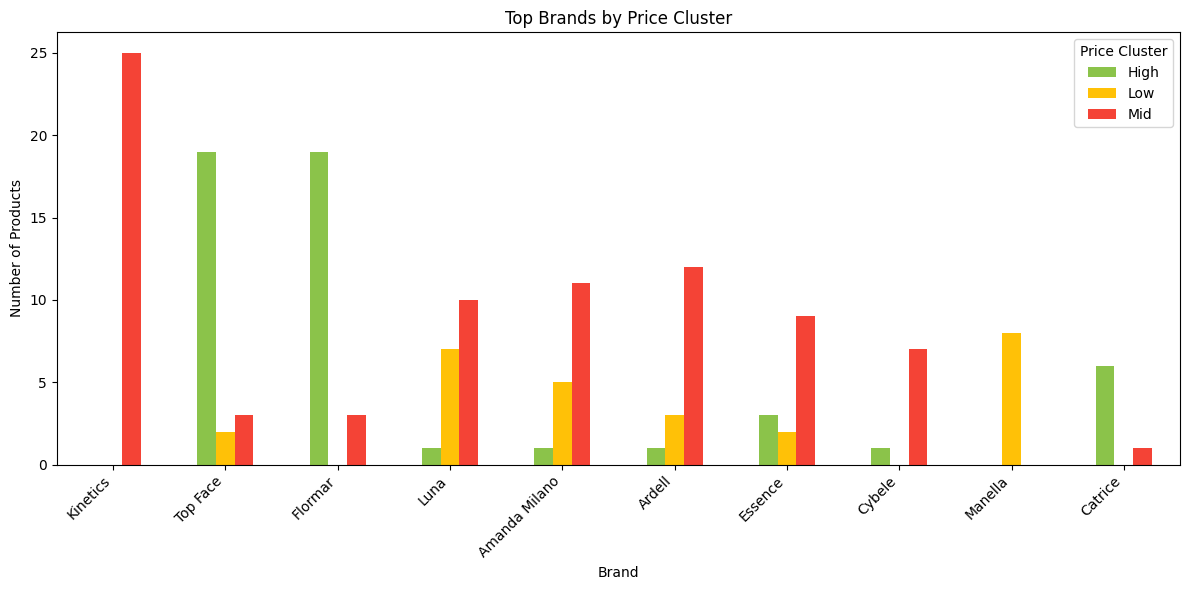

In [183]:
low["cluster"] = "Low"
mid["cluster"] = "Mid"
high["cluster"] = "High"

# Combine all into one
combined_df = pd.concat([low, mid, high], ignore_index=True)

# Group by brand and cluster
brand_cluster_counts = (
    combined_df.groupby(["brand", "cluster"])
    .size()
    .reset_index(name="count")
)

# Pivot to get one row per brand with columns for each cluster
pivot_df = brand_cluster_counts.pivot(index="brand", columns="cluster", values="count").fillna(0)

# Sort brands by total count and keep top 10
top_brands = pivot_df.sum(axis=1).sort_values(ascending=False).head(10)
pivot_df = pivot_df.loc[top_brands.index]

# Plot
pivot_df.plot(kind="bar", stacked=False, color=["#8BC34A", "#FFC107", "#F44336"], figsize=(12, 6))
plt.title("Top Brands by Price Cluster")
plt.xlabel("Brand")
plt.ylabel("Number of Products")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Price Cluster")
plt.tight_layout()
plt.show()

In [57]:
"""from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# 1. Run DBSCAN on existing scaled price
dbscan = DBSCAN(eps=0.05, min_samples=5)
df_cleaned["dbscan_cluster"] = dbscan.fit_predict(df_cleaned[["price_scaled"]])

# 2. Compare number of clusters
n_kmeans = df_cleaned["final_cluster"].nunique()
n_dbscan = df_cleaned["dbscan_cluster"].nunique() - (1 if -1 in df_cleaned["dbscan_cluster"].unique() else 0)

print(f"KMeans clusters: {n_kmeans}")
print(f"DBSCAN clusters: {n_dbscan} (+ noise)")

# 3. Visual comparison
plt.figure(figsize=(12, 6))

# KMeans plot
plt.subplot(1, 2, 1)
plt.scatter(df_cleaned["price_numeric"], [0]*len(df_cleaned),
            c=df_cleaned["final_cluster"], cmap="tab10", alpha=0.7)
plt.title("KMeans Clustering (Actual Price)")
plt.xlabel("Price (SAR)")
plt.yticks([])

# DBSCAN plot
plt.subplot(1, 2, 2)
plt.scatter(df_cleaned["price_numeric"], [0]*len(df_cleaned),
            c=df_cleaned["dbscan_cluster"], cmap="tab10", alpha=0.7)
plt.title("DBSCAN Clustering (Actual Price)")
plt.xlabel("Price (SAR)")
plt.yticks([])

plt.tight_layout()
plt.show()
"""

'from sklearn.cluster import DBSCAN\nimport matplotlib.pyplot as plt\n\n# 1. Run DBSCAN on existing scaled price\ndbscan = DBSCAN(eps=0.05, min_samples=5)\ndf_cleaned["dbscan_cluster"] = dbscan.fit_predict(df_cleaned[["price_scaled"]])\n\n# 2. Compare number of clusters\nn_kmeans = df_cleaned["final_cluster"].nunique()\nn_dbscan = df_cleaned["dbscan_cluster"].nunique() - (1 if -1 in df_cleaned["dbscan_cluster"].unique() else 0)\n\nprint(f"KMeans clusters: {n_kmeans}")\nprint(f"DBSCAN clusters: {n_dbscan} (+ noise)")\n\n# 3. Visual comparison\nplt.figure(figsize=(12, 6))\n\n# KMeans plot\nplt.subplot(1, 2, 1)\nplt.scatter(df_cleaned["price_numeric"], [0]*len(df_cleaned),\n            c=df_cleaned["final_cluster"], cmap="tab10", alpha=0.7)\nplt.title("KMeans Clustering (Actual Price)")\nplt.xlabel("Price (SAR)")\nplt.yticks([])\n\n# DBSCAN plot\nplt.subplot(1, 2, 2)\nplt.scatter(df_cleaned["price_numeric"], [0]*len(df_cleaned),\n            c=df_cleaned["dbscan_cluster"], cmap="tab10", a

In [58]:
"""from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

eps_values = np.linspace(0.1, 1.5, 30)
n_clusters_list = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(df_cleaned[["price_scaled"]])
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_clusters_list.append(n_clusters)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(eps_values, n_clusters_list, marker='o')
plt.title("DBSCAN: Number of Clusters vs eps")
plt.xlabel("eps")
plt.ylabel("Number of clusters")
plt.grid(True)
plt.show()
"""

'from sklearn.cluster import DBSCAN\nimport matplotlib.pyplot as plt\n\neps_values = np.linspace(0.1, 1.5, 30)\nn_clusters_list = []\n\nfor eps in eps_values:\n    db = DBSCAN(eps=eps, min_samples=5)\n    labels = db.fit_predict(df_cleaned[["price_scaled"]])\n    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)\n    n_clusters_list.append(n_clusters)\n\n# Plot\nplt.figure(figsize=(8, 4))\nplt.plot(eps_values, n_clusters_list, marker=\'o\')\nplt.title("DBSCAN: Number of Clusters vs eps")\nplt.xlabel("eps")\nplt.ylabel("Number of clusters")\nplt.grid(True)\nplt.show()\n'